In [1]:
#Set up workspace
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pysal
import statsmodels.api as sm
# from pysal import W, lat2W
# from pysal.cg.kdtree import KDTree
import os
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import seaborn.apionly as sns
from collections import Counter
from pandas.api.types import is_numeric_dtype

/Users/filipmichalsky/anaconda3/envs/my_tf_env/lib/python3.6/site-packages/pysal/lib/weights/util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
/Users/filipmichalsky/anaconda3/envs/my_tf_env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/filipmichalsky/anaconda3/envs/my_tf_env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/filipmichalsky/anaconda3/envs/my_tf_env/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on impo

In [2]:
#Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Miami = pd.read_csv('MunRoll - 00 RE - All Properties.csv')
Miami = pd.read_csv('Miami_geocoded.csv')

len(Miami)

916460

In [4]:
#Drop Nan Address
Miami_df = Miami.dropna(subset=['Property_Address'])

In [5]:
#Subset just the relevant fields for this project
rel_fields = ['Longitude','Latitude','Property_Address','Property_City','Property_Zip','Year','Land','Bldg','Total','Assessed','Land_Use',
              'Zoning','AdjustedSqFt','LotSize','Bed','Bath','Stories','Units','YearBuilt','EffectiveYearBuilt',
             'Sale_Date_1','Sale_Amt_1','Sale_Date_2','Sale_Amt_2','Sale_Date_3','Sale_Amt_3','LivingSqFt','ActualSqFt']



In [6]:
Miami_df = Miami_df[rel_fields]

In [7]:
#Subset just those properties that have had at least one recorded sale
Miami_sales = Miami_df.dropna(subset=['Sale_Amt_1'])

In [8]:
#Let's subset just residential properties
res_uses = ['8907 - MUNICIPAL : CONDOMINIUM - RESIDENTIAL','0007 - VACANT RESIDENTIAL: CONDO','0102 - RESIDENTIAL - SINGLE FAMILY : ADDITIONAL LIVING QUARTERS',
           '0104 - RESIDENTIAL - SINGLE FAMILY : RESIDENTIAL - TOTAL VALUE','8607 - COUNTY : CONDOMINIUM - RESIDENTIAL',
           '0105 - RESIDENTIAL - SINGLE FAMILY : CLUSTER HOME','0081 - VACANT RESIDENTIAL : VACANT LAND','0101 - RESIDENTIAL - SINGLE FAMILY : 1 UNIT',
           '0470 - RESIDENTIAL - TOTAL VALUE : TOWNHOUSE W/ ADDITIONAL LIVING QUARTERS','5001 - IMPR AGRI : RESIDENTIAL - SINGLE FAMILY',
           '0066 - VACANT RESIDENTIAL : EXTRA FEA OTHER THAN PARKING','0508 - COOPERATIVE - RESIDENTIAL : COOPERATIVE - RESIDENTIAL',
           '0423 - RESIDENTIAL - TOTAL VALUE : CONDOMINIUM - TIMESHARING','1211 - MIXED USE-STORE/RESIDENTIAL : RETAIL OUTLET',
           '1209 - MIXED USE-STORE/RESIDENTIAL : MIXED USE - RESIDENTIAL','0724 - MISCELLANEOUS - RESIDENTIAL : CAMPSITE',
           '0451 - RESIDENTIAL - TOTAL VALUE : COMMON AREAS','8807 - FEDERAL : CONDOMINIUM - RESIDENTIAL','0420 - RESIDENTIAL - TOTAL VALUE : DOCK - TOTAL VALUE',
           '5009 - IMPR AGRI - NOT HOMESITES : MIXED USE - RESIDENTIAL','0410 - RESIDENTIAL - TOTAL VALUE : TOWNHOUSE','0407 - RESIDENTIAL - TOTAL VALUE : CONDOMINIUM - RESIDENTIAL',
           '0709 - MISCELLANEOUS - RESIDENTIAL : MIXED USE - RESIDENTIAL','8601 - COUNTY : RESIDENTIAL - SINGLE FAMILY','0005 - VACANT RESIDENTIAL : CLUSTER HOME',
           '1229 - MIXED USE-STORE/RESIDENTIAL : MIXED USE - COMMERCIAL']

In [9]:
#Get the residential subset (we can see that this is most of the dataset)
resi_sales = Miami_sales[Miami_sales['Land_Use'].isin(res_uses)]

In [10]:
resi_sales.shape

(741804, 28)

In [11]:
#Let's clean the data of obvious mistakes so that we can do EDA

#Get rid of mistakes in year built
eda_df = resi_sales[resi_sales['YearBuilt']>1900]
eda_df = eda_df[eda_df['YearBuilt']<2020]

#...Sale Price
eda_df = eda_df[eda_df['Sale_Amt_1']<40000000]
eda_df = eda_df[eda_df['Sale_Amt_1']>10000]

#...SF
eda_df = eda_df[pd.to_numeric(eda_df['ActualSqFt'],errors='coerce').notnull()] 
eda_df['ActualSqFt'] = eda_df['ActualSqFt'].convert_objects(convert_numeric=True).dropna()
eda_df['ActualSqFt'] = eda_df['ActualSqFt'].astype(float)
#eda_df = eda_df[eda_df['ActualSqFt'].apply(lambda x: x.isnumeric())]

eda_df = eda_df[eda_df['ActualSqFt']<20000]
eda_df = eda_df[eda_df['ActualSqFt']>0]

#Add a Price Per Square Foot column
eda_df['PPSF']=eda_df['Sale_Amt_1']/eda_df['ActualSqFt']
eda_df = eda_df.dropna(subset=['PPSF'])

eda_df = eda_df[eda_df['PPSF']<5000]
eda_df = eda_df[eda_df['PPSF']>0]

eda_df = eda_df[eda_df['Longitude']>-82]
eda_df = eda_df[eda_df['Latitude']<27]

len(eda_df)

/Users/filipmichalsky/anaconda3/envs/my_tf_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  del sys.path[0]


525058

In [15]:
eda_df.head()

,Longitude,Latitude,Property_Address,Property_City,Property_Zip,Year,Land,Bldg,Total,Assessed,...,EffectiveYearBuilt,Sale_Date_1,Sale_Amt_1,Sale_Date_2,Sale_Amt_2,Sale_Date_3,Sale_Amt_3,LivingSqFt,ActualSqFt,PPSF
36,-80.200,25.784,1028 NW 3 AVE,Miami,33136-3308,2018.000,475000.000,146758.000,621758.000,338400.000,...,1938.000,4/1/2003 0:00,125000.000,12/1/1990 0:00,0.000,5/1/1983 0:00,95000.000,5985.000,5985.000,20.886
37,-80.200,25.784,1034 NW 3 AVE,Miami,33136-3308,2018.000,450000.000,134757.000,584757.000,584757.000,...,1950.000,3/3/2016 0:00,700000.000,2/19/2016 0:00,0.000,2/12/2015 0:00,535000.000,5679.000,5679.000,123.261
201,-80.200,25.782,801 NW 3 AVE,Miami,33136-3303,2018.000,712500.000,554566.000,1267066.000,565902.000,...,1930.000,10/15/2009 0:00,410000.000,8/1/2001 0:00,215000.000,1/1/1977 0:00,386600.000,11219.000,11219.000,36.545
226,-80.202,25.781,700 NW 4 AVE,Miami,33136-3800,2018.000,105000.000,72361.000,177361.000,145597.000,...,1954.000,12/1/1986 0:00,44000.000,NaN,nan,NaN,nan,2632.000,2632.000,16.717
454,-80.192,25.777,234 NE 1 AVE,Miami,33132-2102,2018.000,4500000.000,10000.000,4510000.000,1626615.000,...,1950.000,10/1/2004 0:00,1700000.000,4/1/1977 0:00,1.000,NaN,nan,8080.000,8080.000,210.396


In [14]:
eda_df['Property_Address'].nunique()

524858

Let's do some EDA

(1910, 2018)

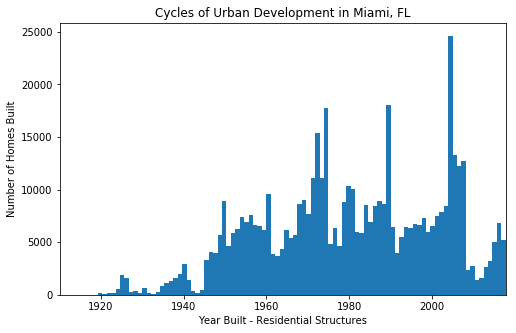

In [11]:
#Building Age
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(eda_df.YearBuilt,bins=110)
ax.set_xlabel('Year Built - Residential Structures')
ax.set_ylabel('Number of Homes Built')
ax.set_title('Cycles of Urban Development in Miami, FL')
ax.set_xlim([1910,2018])

Note the cyclicality implied in the chart above - clearly, there are cycles of intense construction followed by collapses. This could be an interesting thing to explore. 

(10000, 1000000)

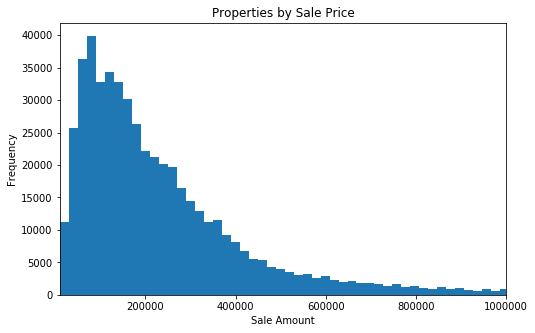

In [12]:
#Latest Sale Price
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(eda_df['Sale_Amt_1'],bins=2000)
ax.set_xlabel('Sale Amount')
ax.set_ylabel('Frequency')
ax.set_title('Properties by Sale Price')
ax.set_xlim([10000,1000000])

(100, 6000)

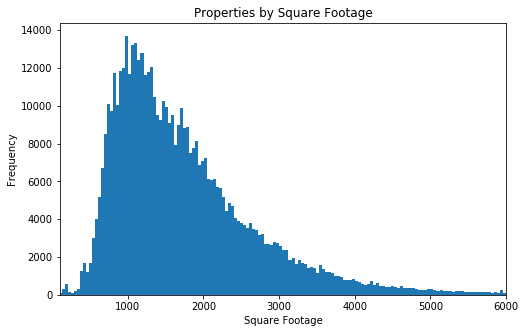

In [13]:
#Square Footage
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(eda_df['ActualSqFt'],bins=500)
ax.set_xlabel('Square Footage')
ax.set_ylabel('Frequency')
ax.set_title('Properties by Square Footage')
ax.set_xlim([100,6000])

(0, 1000)

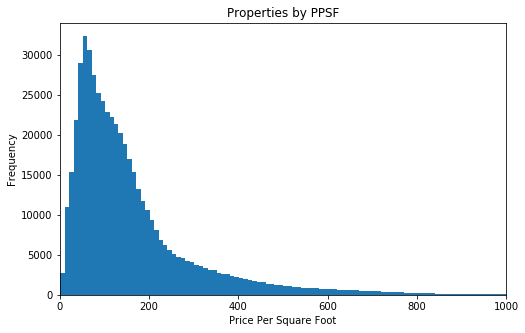

In [14]:
#PPSF
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(eda_df['PPSF'],bins=500)
ax.set_xlabel('Price Per Square Foot')
ax.set_ylabel('Frequency')
ax.set_title('Properties by PPSF')
ax.set_xlim([0,1000])

In [15]:
#Let's try plotting some heatmaps

def plot_heatmap(df,value,colors='Blues',gridsize=80,title='Map',cb_label='Scale',
                vmin=0,vmax=1000):
    long = df['Longitude'].values
    lat = df['Latitude'].values
    
    margin = .04 # buffer to add to the range

    y_min = min(lat) - margin
    y_max = max(lat) + margin
    x_min = min(long) - margin
    x_max = max(long) + margin
        
    if value!='Abs_Residuals':
        fig = plt.figure(figsize=(27,20))
        ax = fig.add_subplot(221)
        #ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=-100, vmax=100,gridsize=gridsize, cmap=colors)
        ax.hexbin(df['Longitude'],df['Latitude'],df[value],vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(title)
    
        #hb = ax.hexbin(df['DisplayX'],df['DisplayY'],df[value]*100, vmin=-100, vmax=100,gridsize=gridsize, cmap=colors)
        hb = ax.hexbin(df['Longitude'],df['Latitude'],df[value], vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label(cb_label)
        #ax.colorbar(hb, ax=ax)
        plt.ylim([y_min, y_max])
        plt.xlim([x_min, x_max])
    else:
        fig = plt.figure(figsize=(27,20))
        ax = fig.add_subplot(221)
        ax.hexbin(df['Longitude'],df['Latitude'],df[value]*100, vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(title)
    
        hb = ax.hexbin(df['Longitude'],df['Latitude'],df[value]*100, vmin=vmin,vmax=vmax,gridsize=gridsize, cmap=colors)
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label(cb_label)
        #ax.colorbar(hb, ax=ax)
        plt.ylim([y_min, y_max])
        plt.xlim([x_min, x_max])       
    
    plt.show()

In [21]:
eda_df.shape

(525058, 29)

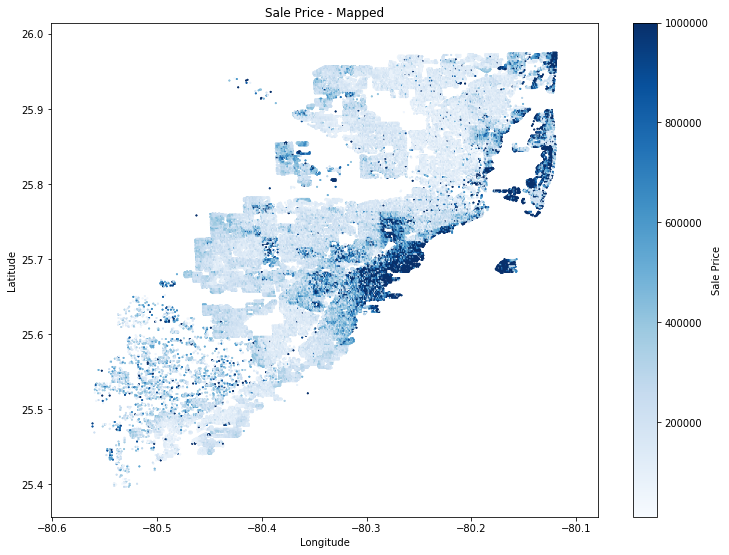

In [22]:
plot_heatmap(eda_df,value='Sale_Amt_1',gridsize=500,vmin=10000,vmax=1000000,title="Sale Price - Mapped",cb_label = 'Sale Price')


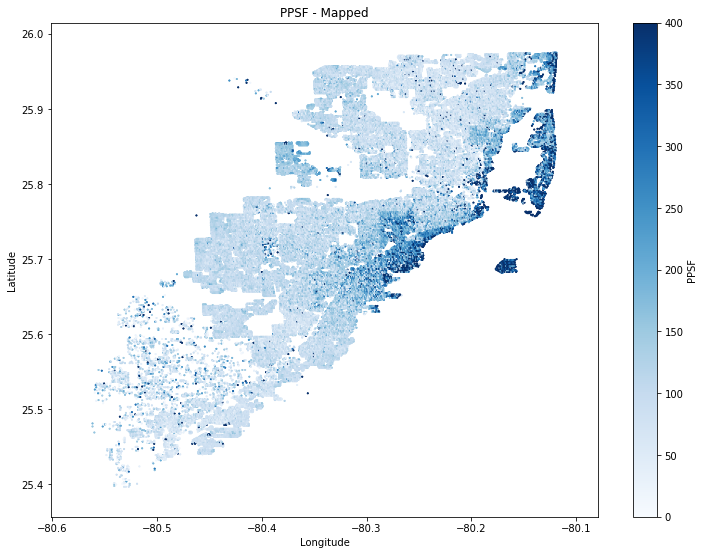

In [17]:
plot_heatmap(eda_df,value='PPSF',gridsize=500,vmin=0,vmax=400,title="PPSF - Mapped",cb_label = 'PPSF')


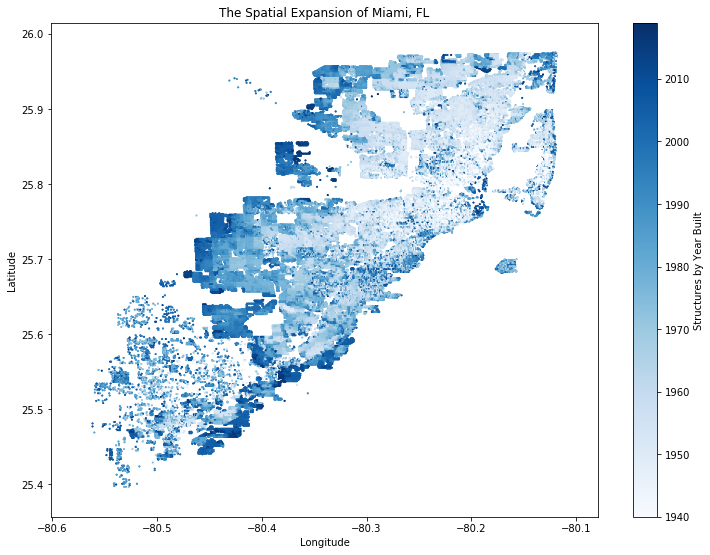

In [20]:
plot_heatmap(eda_df,value='YearBuilt',gridsize=500,vmin=1940,vmax=2019,title="The Spatial Expansion of Miami, FL",cb_label = 'Structures by Year Built')


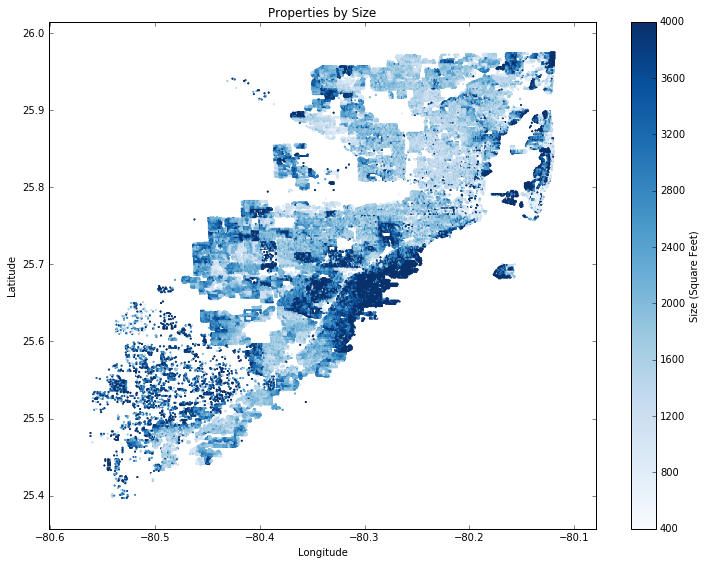

In [70]:
plot_heatmap(eda_df,value='ActualSqFt',gridsize=500,vmin=400,vmax=4000,title="Properties by Size",cb_label = 'Size (Square Feet)')


Next step: divide up dataset so that each row is a single sale (not a single property). I.e. make this a dataset with ~2.5M transactions. 

In [71]:
rel_fields_1 = ['Longitude','Latitude','Property_Address','Property_City','Property_Zip','Year','Land','Bldg','Total','Assessed','Land_Use',
              'Zoning','AdjustedSqFt','LotSize','Bed','Bath','Stories','Units','YearBuilt','EffectiveYearBuilt',
                'Sale_Date_1','Sale_Amt_1','LivingSqFt','ActualSqFt']

rel_fields_2 = ['Longitude','Latitude','Property_Address','Property_City','Property_Zip','Year','Land','Bldg','Total','Assessed','Land_Use',
              'Zoning','AdjustedSqFt','LotSize','Bed','Bath','Stories','Units','YearBuilt','EffectiveYearBuilt',
                'Sale_Date_2','Sale_Amt_2','LivingSqFt','ActualSqFt']

rel_fields_3 = ['Longitude','Latitude','Property_Address','Property_City','Property_Zip','Year','Land','Bldg','Total','Assessed','Land_Use',
              'Zoning','AdjustedSqFt','LotSize','Bed','Bath','Stories','Units','YearBuilt','EffectiveYearBuilt',
                'Sale_Date_3','Sale_Amt_3','LivingSqFt','ActualSqFt']


In [72]:
eda_df['Sale_1'] = list(eda_df['Sale_Amt_1']>0)
eda_df['Sale_2'] = list(eda_df['Sale_Amt_2']>0)
eda_df['Sale_3'] = list(eda_df['Sale_Amt_3']>0)



In [73]:
sales_df_1 = eda_df[eda_df['Sale_1']==True]
sales_df_2 = eda_df[eda_df['Sale_2']==True]
sales_df_3 = eda_df[eda_df['Sale_3']==True]

sales_df_1 = sales_df_1[rel_fields_1]
sales_df_2 = sales_df_2[rel_fields_2]
sales_df_3 = sales_df_3[rel_fields_3]

sales_df_1 = sales_df_1.rename(columns={'Sale_Amt_1':'Sale_price','Sale_Date_1':'Sale_Date'})
sales_df_2 = sales_df_2.rename(columns={'Sale_Amt_2':'Sale_price','Sale_Date_2':'Sale_Date'})
sales_df_3 = sales_df_3.rename(columns={'Sale_Amt_3':'Sale_price','Sale_Date_3':'Sale_Date'})

In [74]:
sales_df = pd.concat([sales_df_1,sales_df_2,sales_df_3])

In [75]:
sales_df['Sale_Date'] = pd.to_datetime(sales_df['Sale_Date'])

In [76]:
sale_year = []
for i in list(sales_df['Sale_Date']):
    sale_year.append(i.year)
    
sales_df = sales_df.assign(Sale_Year = sale_year)

(1970, 2018)

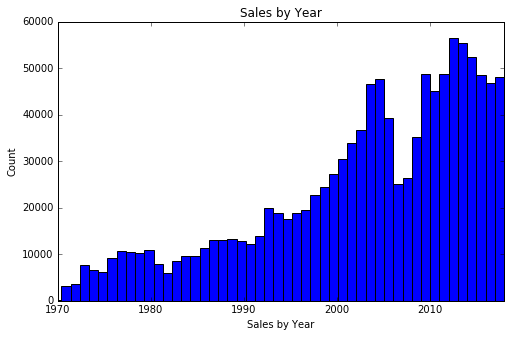

In [77]:
#Sales by Year
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.hist(sales_df.Sale_Year,bins=120)
ax.set_xlabel('Sales by Year')
ax.set_ylabel('Count')
ax.set_title('Sales by Year')
ax.set_xlim([1970,2018])

In [78]:
years = list(set(sales_df['Sale_Year']))

In [79]:
years.remove(1900)
years.remove(1911)
years.remove(1918)

In [80]:
yearly_prices = []
for year in years:
    year_df = sales_df[sales_df['Sale_Year']==year]
    avg_price = np.mean(year_df['Sale_price'])
    yearly_prices.append(avg_price)

In [81]:
Yearly_prices = pd.DataFrame(
        {'Year': years,
         'Sale_Price': yearly_prices})

In [82]:
Yearly_prices = Yearly_prices[Yearly_prices['Year']>1969]

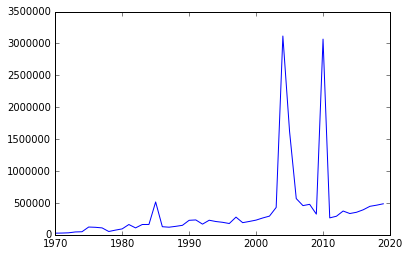

In [83]:
plt.plot(Yearly_prices['Year'],Yearly_prices['Sale_Price'])